In [1]:
! python --version
import torch
print(torch.__version__)  # Verifica la versión instalada
print(torch.cuda.is_available())  # Verifica si CUDA está disponible
print(torch.version.cuda)  # Verifica la versión de CUDA en PyTorch



Python 3.9.13


ModuleNotFoundError: No module named 'torch'

# 🚚 **Entregables**

**No olvide duplicar esta notebook para poder editar: File->Save a copy in Drive**

En este laboratorio, no es necesario redactar un informe en un documento separado. Por favor, complete todas las actividades requeridas dentro de esta notebook de Google Colab. Recuerde que una notebook le permite ingresar elementos de texto de manera similar a un procesador de documentos. Una vez finalizadas las actividades propuestas, deberá entregar lo siguiente en la plataforma:

1. Un archivo PDF generado en Google Colab desde el menú "Archivo" -> "Imprimir".

2. El enlace público de Google Colab. Para ello, vaya al botón de compartir y cambie la configuración de compartición a "Cualquier persona con el enlace".

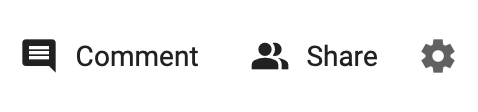

# Probabilistic Graphical Models

 We first install the pgmpy Python package, which is used for working with Probabilistic Graphical Models.

In [ ]:
#%%capture
!pip install pgmpy

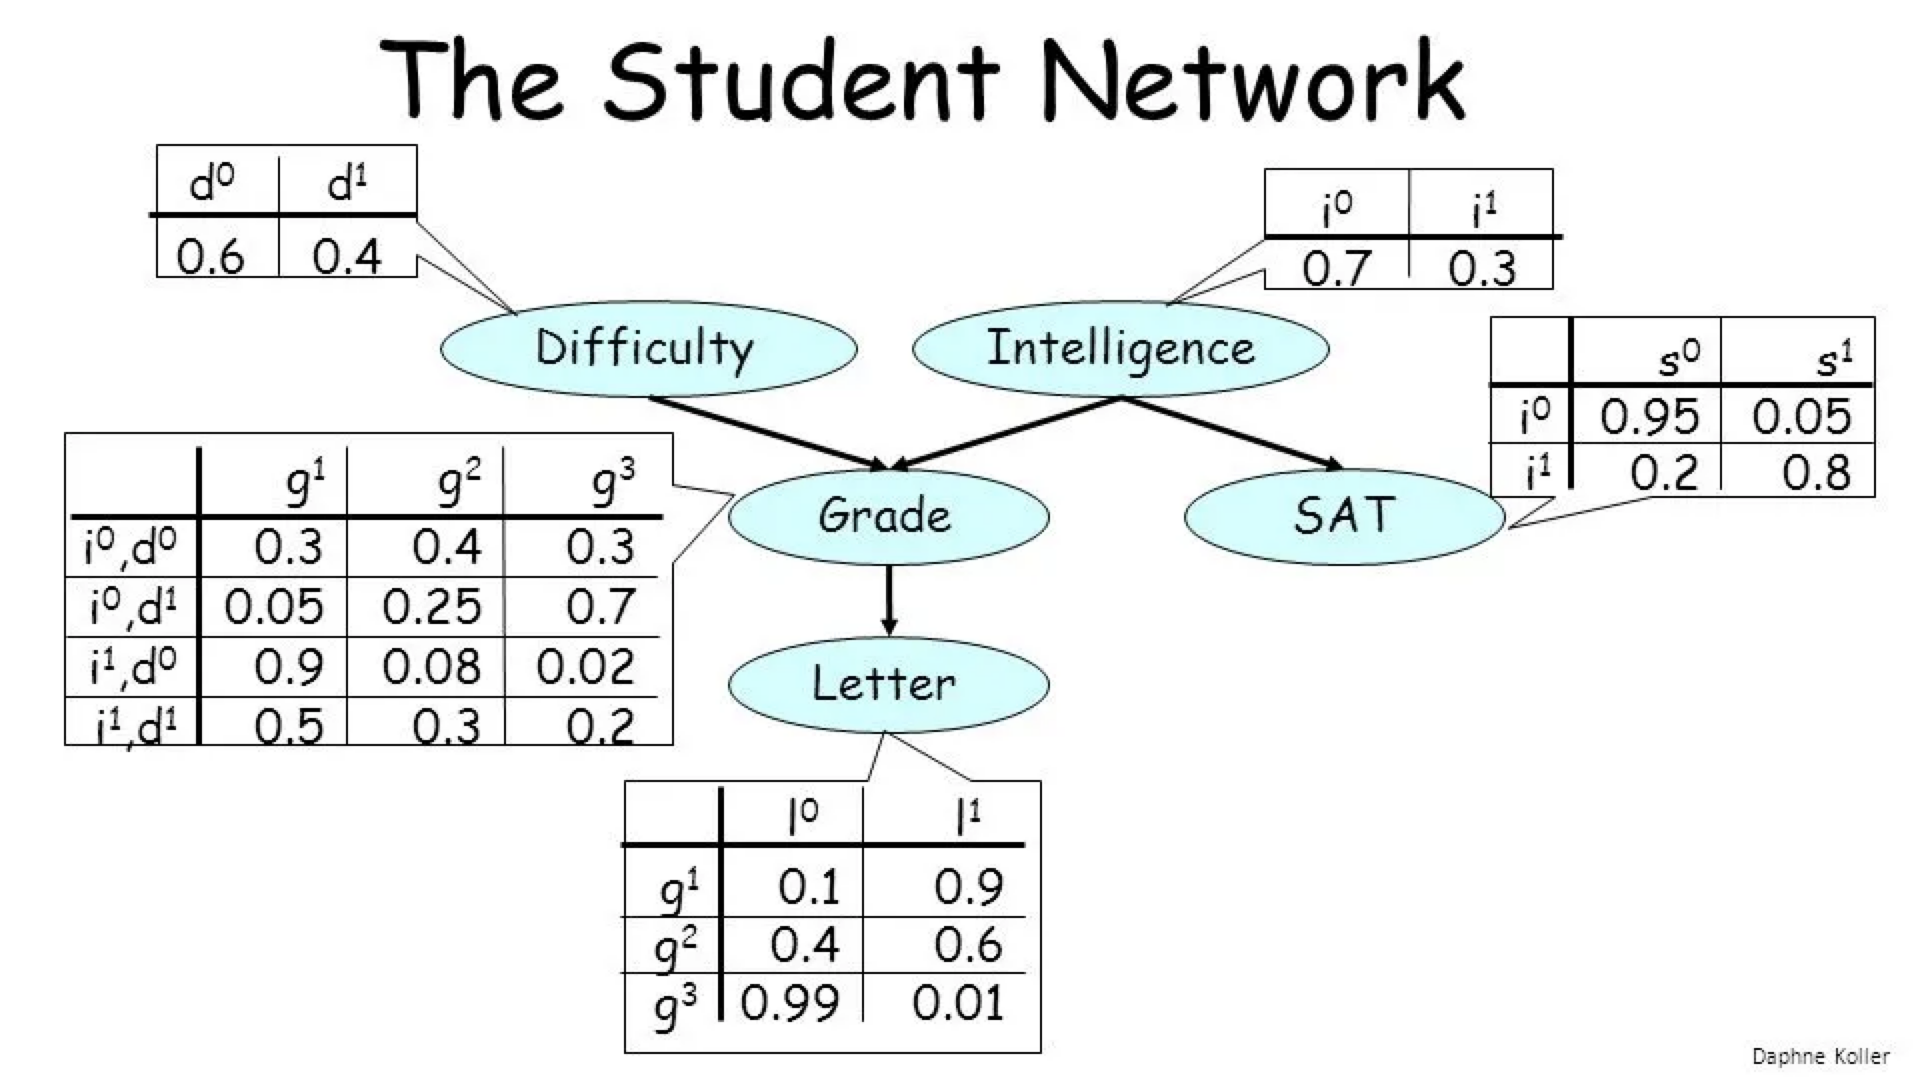

## Defining the model

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Define the model
model = DiscreteBayesianNetwork([('Difficulty', 'Grade'),
                         ('Intelligence', 'Grade'),
                         ('Intelligence', 'SAT'),
                         ('Grade', 'Letter')])

# Define the CPDs
cpd_difficulty = TabularCPD(variable='Difficulty', variable_card=2, values=[[0.6], [0.4]])
cpd_intelligence = TabularCPD(variable='Intelligence', variable_card=2, values=[[0.7], [0.3]])
# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture.
# In pgmpy the colums are the evidences and rows are the states of the variable.
# So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | intel   | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | diff    | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_3 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_grade = TabularCPD(variable='Grade', variable_card=3, #evidence_card = cardinality
                       values=[[0.3, 0.05, 0.9, 0.5],
                               [0.4, 0.25, 0.08, 0.3],
                               [0.3, 0.7, 0.02, 0.2]],
                       evidence=['Intelligence', 'Difficulty'],
                       evidence_card=[2, 2])
cpd_sat = TabularCPD(variable='SAT', variable_card=2,
                     values=[[0.95, 0.2],
                             [0.05, 0.8]],
                     evidence=['Intelligence'],
                     evidence_card=[2])
cpd_letter = TabularCPD(variable='Letter', variable_card=2,
                        values=[[0.1, 0.4, 0.99],
                                [0.9, 0.6, 0.01]],
                        evidence=['Grade'],
                        evidence_card=[3])

# Add CPDs to the model
model.add_cpds(cpd_difficulty, cpd_intelligence, cpd_grade, cpd_sat, cpd_letter)

# check for errors
assert model.check_model()




g:\Mi unidad\Colab Notebooks\IA\Semana_3\lpvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Detailed Code Explanation

The following Python code defines a Bayesian Network using the `pgmpy` library. Here's a brief explanation of what each part of the code does:

### 1. **Importing Necessary Modules:**
   - **`BayesianNetwork`**: Used to define the structure of the Bayesian Network.
   - **`TabularCPD`**: Represents the Conditional Probability Distributions (CPDs) for each variable in the network.
   - **`VariableElimination`**: A class for performing inference using the Variable Elimination algorithm.

### 2. **Defining the Bayesian Network Structure:**
   - **`model = BayesianNetwork([...])`**:
     - This line defines the structure of the Bayesian Network using directed edges between nodes.
     - The edges represent conditional dependencies between variables, e.g., `('Difficulty', 'Grade')` means "Grade" depends on "Difficulty."

### 3. **Defining the CPDs:**
   - **`TabularCPD(variable=..., values=...)`**:
     - CPDs are defined for each variable, showing the probability distributions conditioned on parent variables.
     - For instance, `cpd_grade` defines the probability distribution of "Grade" given "Intelligence" and "Difficulty".
   - **`variable_card`**: Specifies the number of possible states the variable can take.
   - **`evidence` and `evidence_card`**: Specify the parent variables and their number of states (used only when the variable has parents).

### 4. **Adding CPDs to the Model:**
   - **`model.add_cpds(...)`**:
     - The defined CPDs are added to the Bayesian Network.
   - **`model.check_model()`**:
     - Ensures that the model is correctly specified, checking that the CPDs are consistent with the network structure.





## Model Visualization

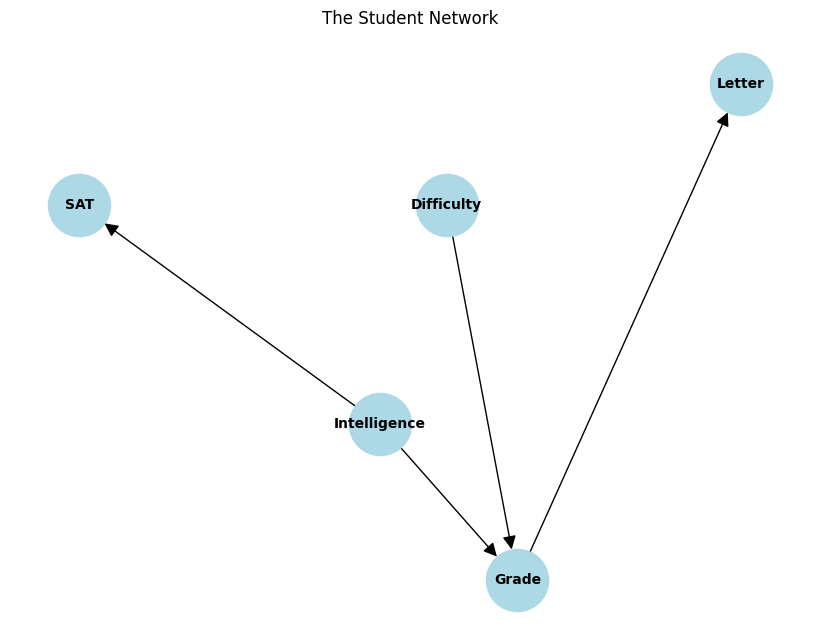

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from the model
nx_graph = nx.DiGraph()

# Add edges from the Bayesian Network
nx_graph.add_edges_from(model.edges())

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(nx_graph, k=2, iterations=150, seed=30)  # Adjust 'k' for node spacing
nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', arrowsize=20)
plt.title("The Student Network")
plt.show()

## Inference with Variable Elimination

We perform inference with Variable elimination:
   - **`infer = VariableElimination(model)`**:
     - Sets up an inference engine using the Variable Elimination algorithm, which can be used to query the network (e.g., to compute marginal probabilities or conditional probabilities).

In [ ]:
# Inference with Variable Elimination
infer = VariableElimination(model)

Let's make some marginal and MAP queries

In [ ]:
# What is the probability of receiving a recommendation Letter
# given a course with low Difficulty for an Intelligent student?
marginal_result = infer.query(variables=['Letter'], evidence={'Difficulty': 0, 'Intelligence': 1})
print("Marginal probabilities: \n", marginal_result)

#Given an Intelligent student in a low-Difficulty course,
# is she going to receive a recommendation Letter?
map_result = infer.map_query(variables=['Letter'], evidence={'Difficulty': 0, 'Intelligence': 1})
print("MAP Result:", map_result)

print("*"*100)

#result = infer.query(variables=['Grade'], evidence={'Difficulty': 0, 'Intelligence': 1})
#print(result)

marginal_result = infer.query(variables=['SAT','Letter'], evidence={'Difficulty': 0, 'Intelligence': 1})
print("Marginal probabilities: \n", marginal_result)
map_result = infer.map_query(variables=['SAT','Letter'], evidence={'Difficulty': 0, 'Intelligence': 1})
print("MAP Result:", map_result)



Marginal probabilities: 
 +-----------+---------------+
| Letter    |   phi(Letter) |
+===========+===============+
| Letter(0) |        0.1418 |
+-----------+---------------+
| Letter(1) |        0.8582 |
+-----------+---------------+


Eliminating: Grade: 100%|██████████| 1/1 [00:00<00:00, 625.27it/s]


MAP Result: {'Letter': 1}
****************************************************************************************************
Marginal probabilities: 
 +--------+-----------+-------------------+
| SAT    | Letter    |   phi(SAT,Letter) |
+========+===========+===================+
| SAT(0) | Letter(0) |            0.0284 |
+--------+-----------+-------------------+
| SAT(0) | Letter(1) |            0.1716 |
+--------+-----------+-------------------+
| SAT(1) | Letter(0) |            0.1134 |
+--------+-----------+-------------------+
| SAT(1) | Letter(1) |            0.6866 |
+--------+-----------+-------------------+


Eliminating: Grade: 100%|██████████| 1/1 [00:00<?, ?it/s]

MAP Result: {'SAT': 1, 'Letter': 1}


## ✅ Activity: Naive Bayes Classifier



```
Fruit           Long | Not Long || Sweet | Not Sweet || Yellow |Not Yellow|Total
             ___________________________________________________________________
Banana      |  400  |    100   || 350   |    150    ||  450   |  50      |  500
Orange      |    0  |    300   || 150   |    150    ||  300   |   0      |  300
Other Fruit |  100  |    100   || 150   |     50    ||   50   | 150      |  200
            ____________________________________________________________________
Total       |  500  |    500   || 650   |    350    ||  800   | 200      | 1000
             ___________________________________________________________________
```








1. Draw the PGM for the Naive Bayes classifier assuming that the Class is the `Fruit` and the features are `Long`, `Sweet` and `Yellow`

2. Write the Joint Probability Distribution expression. Hint: use  the factorization rule over the graph

3. Calculate by hand the Conditional Probability Distributions (CPDs) of all random variables: `Fruit`, `Long`, `Sweet` and `Yellow`. Hint: use the counts from the dataset to estimate the CPDs (i.e., you are using Maximum Likelihood Estimation).

For example, for the Fruit random variable since it does not have dependencies:
```
P(Fruit=Banana)=500/1000
P(Fruit=Orange)=300/1000
P(Fruit=Other)=200/1000
```
So, the CDP table look like this (note that the sum equals to one):

```
+--------+--------+-------+
| Banana | Orange | Other |
+--------+--------+-------+
|  0.5   |  0.3   |  0.2  |
+--------+--------+-------+

```





4. Define your naive bayes model using the pgmpy library.

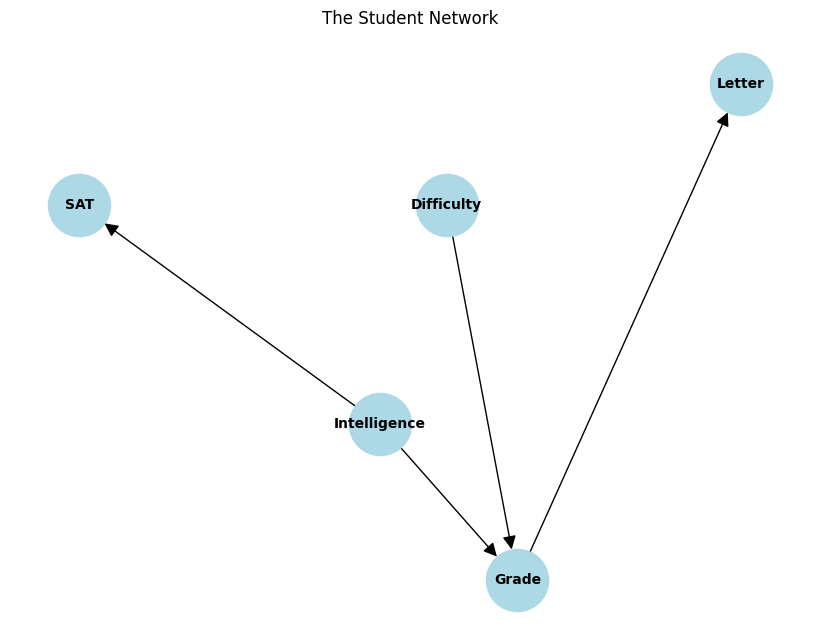

In [7]:
#your code here
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from the model
nx_graph = nx.DiGraph()

# Add edges from the Bayesian Network
nx_graph.add_edges_from(model.edges())

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(nx_graph, k=2, iterations=150, seed=30)  # Adjust 'k' for node spacing
nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', arrowsize=20)
plt.title("The Student Network")
plt.show()

5. Visualize your model using the networkx library. You can use other libraries for visualization of graphs if you want.

In [ ]:
#your code here

6. Perform the following queries using variable elimination with pgmpy. Hint: remember that marginal queries are used to estimate probability distributions and MAP queries are useful to find the most probable explanation.


1.   What is the probability distribution of Fruit given that we observe that it is Long, Sweet and Yellow?
2.   Which class your classifier returns as the most probable fruit if it is Long, Sweet and Yellow?
1.   What is the probability distribution of Fruit given that we observe that it is Not Long, Not Sweet and Not Yellow?
2.   Which class your classifier returns as the most probable fruit if it is Not Long, Not Sweet and Not Yellow?



In [ ]:
#your code here

#Generating Names with Markov Chains: A Bigram Character-Level Model

In this notebook, we will explore Markov Chains, which are powerful models used to represent systems that undergo transitions from one state to another, where the probability of each transition depends only on the current state. This "memoryless" property is a key feature of Markov Models, making them useful for a wide range of applications in areas like natural language processing, robotics, and genetics.

To make this concept more tangible, we will focus on a bigram model, a specific type of Markov Chain. A bigram model captures the probability of a state (in our case, a character) depending on the previous one. This is useful when working with language data because it allows us to predict sequences of characters or words based on their preceding ones.

In this example, we will use a bigram model at the character level to generate names. By learning the transitions between characters in a dataset of names, our model will be able to create new, plausible-sounding names. This process will give you a hands-on understanding of how Markov Chains can be applied to language generation tasks. We will use the implementation from Andrej Karpathy https://github.com/karpathy/nn-zero-to-hero

## Dataset

We load a dataset of names into a list, which we can then use to train our bigram model.

In [ ]:
!curl -o names.txt https://raw.githubusercontent.com/mtgca/datasets_public/main/names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   463k      0 --:--:-- --:--:-- --:--:--  464k


In [ ]:
# Adding a random seed to ensure reproducibility
import random

words = open('names.txt', 'r').read().splitlines()
words[:10]

# Set a random seed for reproducibility
random.seed(22682732222)

# Shuffle the list to randomize the order
random.shuffle(words)

# Split the dataset: 80% for training, 20% for testing
train_size = int(0.8 * len(words))  # 80% for training
train_words = words[:train_size]
test_words = words[train_size:]

# Display the first 3 names from the training set
train_words[:3]


['gissel', 'minh', 'omauri']

In [ ]:
len(words) # number of words
#min(len(w) for w in words) #shortest word 2
#max(len(w) for w in words) #longest word 15

32033

## Character-level tokenization

To generate names using a Markov model, the first step is to break down the text into manageable units, a process called tokenization. Tokenization refers to dividing a sequence of text into smaller pieces called "tokens." These tokens can be words, characters, or even subwords, depending on the specific task at hand.

In this notebook, we will use character-level tokenization, meaning that we treat each individual character (letters, spaces, punctuation) as a token. By learning how one character follows another, our model can capture patterns in the transitions between characters and generate new names character by character. This approach is chosen for educational purposes because it provides an intuitive way to understand how models like Markov chains work when generating text.

In practice, more complex tokenization methods exist. For example, instead of splitting at the character level, we can tokenize at the word level or use subword units, which group multiple characters together. These more advanced methods often perform better for real-world tasks because they capture higher-level patterns in the text.

In [ ]:
chars = sorted(list(set(''.join(words)))) #get all unique chars
print(chars)
print(len(chars))


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
26


In [ ]:
# Character-level tokenization: From char to token
stoi = {s: i+1 for i, s in enumerate(chars)}  # Create a mapping from character to token index
stoi['.'] = 0  # "Special start and end token"
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [ ]:
# Inverse mapping: From token to character
itos = {i: s for s, i in stoi.items()}  # Create a dictionary that maps each token (integer) back to its corresponding character
itos


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Transition Matrix


To understand how characters transition from one to another in our dataset, we construct a **transition matrix**. This matrix captures the frequency of transitions between characters, where each row represents a "from" character and each column represents a "to" character. For example, if the transition from character 'a' to character 'b' occurs frequently in the dataset, the corresponding entry in the matrix will have a higher count.

In this case, we are building an **unnormalized transition matrix**, which simply counts how many times each transition occurs. These raw counts will later allow us to understand the relationships between characters in the dataset. However, because this matrix is unnormalized, the values only reflect counts, not probabilities. We will normalize these counts in a subsequent step to generate probabilistic transitions that can be used to sample new names.


In [ ]:
# Transition Matrix unnormalized (counts)
import torch

# Initialize a 27x27 matrix of zeros, representing transitions between characters.
# 26 letters + 1 for the special start/end token ('.')
N = torch.zeros((27, 27), dtype=torch.int32)

# Iterate through each word in the list of words
for w in train_words:
    # Add the special start ('.') and end ('.') tokens to the word
    chs = ['.'] + list(w) + ['.']

    # Iterate through pairs of consecutive characters (ch1, ch2) in the word
    # zip pairs consecutive characters from the list chs, so that ch1 is
    # the current character and ch2 is the next one.
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]  # Get the token index of the first character (from character)
        ix2 = stoi[ch2]  # Get the token index of the second character (to character)

        # Increment the corresponding entry in the transition matrix
        # N[ix1, ix2] represents the transition count
        # from character ch1 (rows) to ch2 (columns)
        N[ix1, ix2] += 1


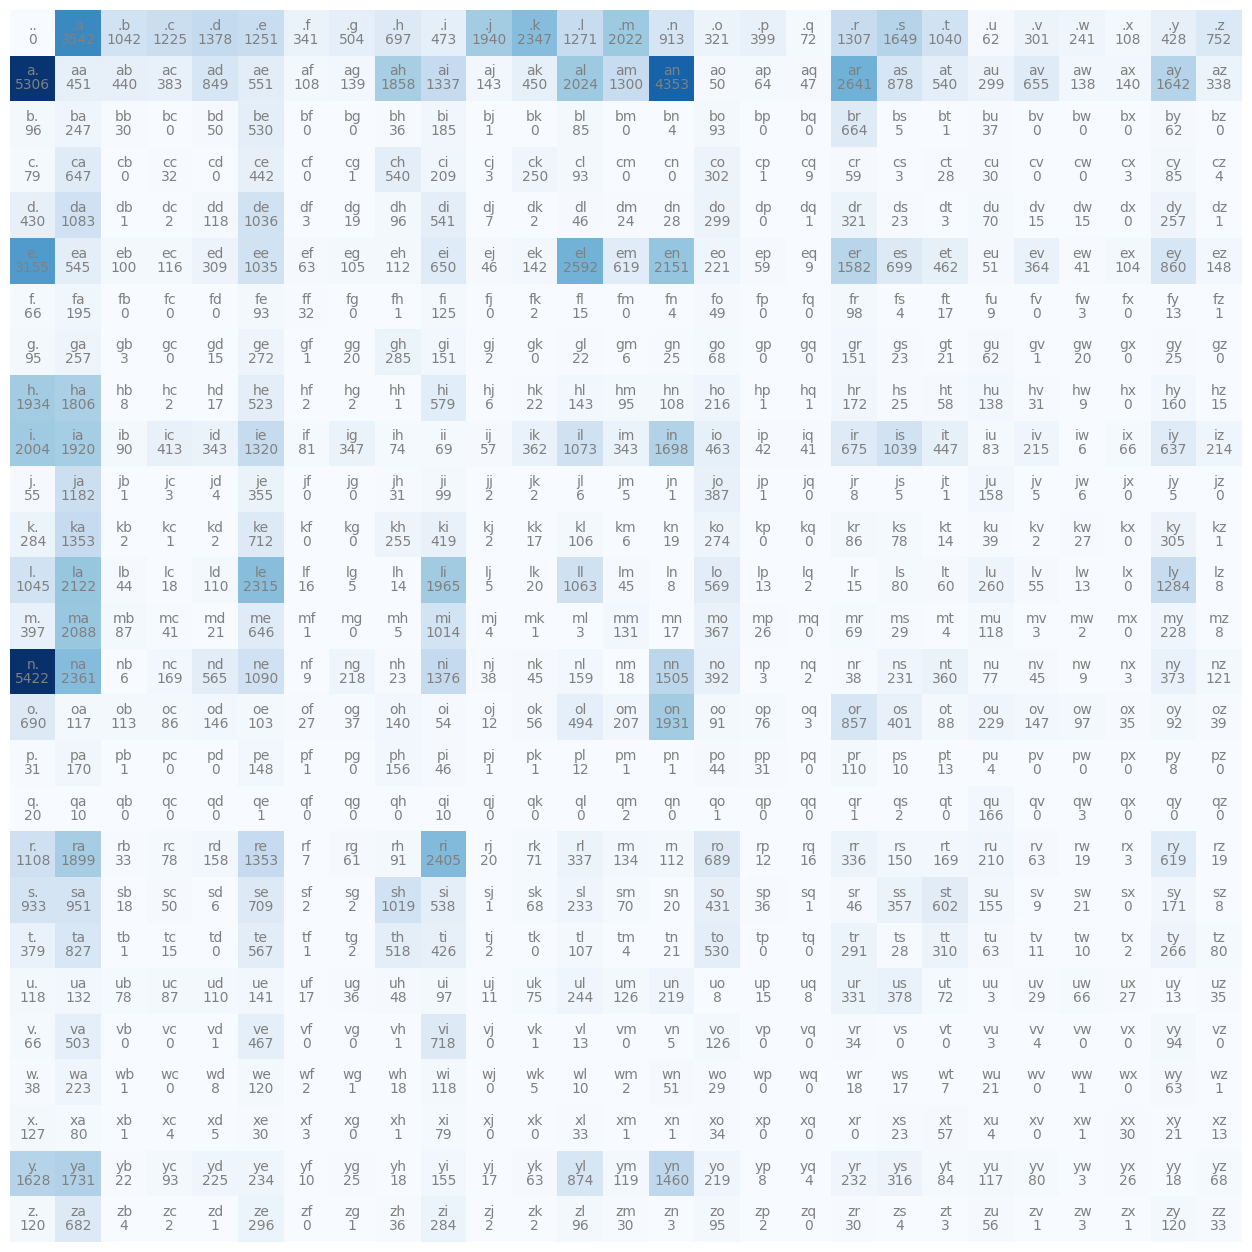

In [ ]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Set the figure size to be 16x16
plt.figure(figsize=(16,16))

# Display the transition matrix (N) as an image, using a blue color map
plt.imshow(N, cmap='Blues')

# Loop through each cell in the 27x27 matrix to annotate it with character pairs and their transition counts
for i in range(27):  # Loop through rows (representing the "from" characters)
    for j in range(27):  # Loop through columns (representing the "to" characters)
        chstr = itos[i] + itos[j]  # Concatenate the characters from the i-th and j-th positions
        # Add the character pair as text in each cell (centered horizontally and aligned to the bottom)
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        # Add the transition count in the same cell (centered horizontally and aligned to the top)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')

# Turn off the axis for a cleaner plot (no ticks, labels, or borders)
plt.axis('off');


### Displaying Counts for the First Row

To better understand how the transition matrix works, we can examine the counts of character transitions from the first row. The following line retrieves the first row of the matrix, which corresponds to the special start token `.`. This row contains 27 values, each representing how often the start token transitions to each character in the dataset, including itself. These counts tell us, for example, how many words in our dataset start with each letter or how often we transition back to the start token at the end of a word.

By displaying this row as an example, we can see how frequently words begin with certain characters and prepare for the normalization process, where these raw counts will be converted into probabilities. This visualization offers insight into the data distribution and the patterns the model will learn to generate new names.

In [ ]:
N[0] #first row, shape 27, equivalent N[0,:]

tensor([   0, 3542, 1042, 1225, 1378, 1251,  341,  504,  697,  473, 1940, 2347,
        1271, 2022,  913,  321,  399,   72, 1307, 1649, 1040,   62,  301,  241,
         108,  428,  752], dtype=torch.int32)

### Normalizing the counts for the first row

Now that we have constructed our unnormalized transition matrix, which contains raw counts of how often each character transitions to the next, the next step is to normalize these counts. Normalization allows us to convert these raw counts into probabilities, which are essential for generating new names based on learned patterns.

We will normalize the matrix by converting the counts into probabilities, ensuring that the sum of all transition probabilities from a given character equals 1. For example, the following code focus on the transitions from the special start token (.) (row 0). First, we convert the counts from integers to floats to allow for division. Then, we divide each count by the total sum of that row, ensuring that the transition probabilities add up to 1.

This process will be repeated for every row in the matrix, allowing us to generate character sequences probabilistically, based on how often each character follows another.

In [ ]:
p = N[0].float()  # Convert the counts in row 0 (for the '.' start token) to floating-point numbers
p = p / p.sum()   # Normalize by dividing each count by the total sum of the row
print("Probs for first row sum to:", p.sum().item())
p


Probs for first row sum to: 1.0


tensor([0.0000, 0.1382, 0.0407, 0.0478, 0.0538, 0.0488, 0.0133, 0.0197, 0.0272,
        0.0185, 0.0757, 0.0916, 0.0496, 0.0789, 0.0356, 0.0125, 0.0156, 0.0028,
        0.0510, 0.0643, 0.0406, 0.0024, 0.0117, 0.0094, 0.0042, 0.0167, 0.0293])


### Normalizing the Entire Transition Matrix

Now that we have our unnormalized transition matrix `N`, which contains the raw counts of character transitions, we need to **normalize** the entire matrix so that the values represent probabilities. The normalization process ensures that the sum of each row (which represents transitions from one character) adds up to 1.

We use the following code to normalize the matrix:

In [ ]:
#normalized transition matrix
P = (N + 1).float()  # Add 1 to every element in N to create "fake counts" (smoothing)
P /= P.sum(1, keepdims=True)  # Normalize by dividing each count by the row sum, across columns
P.shape
#broadcast
#27, 27
#27, 1

torch.Size([27, 27])


1. **Add 1 to the matrix:**
   - We add `1` to every element of `N` to perform **Laplace smoothing** (also called "add-one smoothing"). This ensures that even transitions that didn’t appear in the data (i.e., zero counts) are given a small, non-zero probability, preventing issues with division by zero during normalization.
   
2. **Convert to float:**
   - We convert the matrix to floating-point numbers with `.float()` so that we can perform division for normalization.

3. **Normalize each row:**
   - `P.sum(1, keepdims=True)` sums each row of `P` across the columns (the dimension `1`), ensuring that the total sum of transitions from each character equals 1. The `keepdims=True` argument ensures that the resulting shape remains `(27, 27)` instead of collapsing the rows.

### Broadcasting in PyTorch

In PyTorch, **broadcasting** refers to how operations handle arrays with different shapes. When performing element-wise operations like division, if the shapes of the two tensors don’t match, PyTorch automatically expands the smaller tensor to match the dimensions of the larger one. In our case:

- `P.sum(1, keepdims=True)` results in a `(27, 1)` matrix, which contains the sum of each row.
- We then divide `P` (shape `(27, 27)`) by this `(27, 1)` matrix. Thanks to broadcasting, PyTorch automatically expands the `(27, 1)` tensor to match the `(27, 27)` shape, performing the division row-wise.

This **broadcasting operation** is crucial to understand when working with matrix and tensor operations in PyTorch, as it simplifies the code and avoids manual reshaping.



## Sampling from the Transition Matrix

Now that we have normalized our transition matrix to represent probabilities, we can sample the next character based on these probabilities. The following code demonstrates how to sample from the first row of the transition matrix, which corresponds to the special start token (`.`). This example shows how we can use PyTorch to select the next character probabilistically:



In [ ]:
g = torch.Generator().manual_seed(2147483647)  # Create a random number generator with a fixed seed for reproducibility
p = P[0]  # Take the first row of the normalized transition matrix (probabilities of transitions from the '.' token)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()  # Sample one index from the probability distribution in 'p'
itos[ix]  # Convert the sampled index back to its corresponding character using 'itos'

'j'



1. **`torch.Generator().manual_seed(2147483647)`**:
   - This line initializes a random number generator with a fixed seed (`2147483647`). By setting a seed, we ensure that the results of the sampling are **reproducible**, meaning that each time the code is run, we get the same result.
   
2. **`P[0]`**:
   - This selects the first row of the normalized transition matrix `P`. The first row represents the transition probabilities from the special start token (`.`) to any of the other 27 possible characters. Each value in the row indicates the likelihood of transitioning from `.` to a specific character.
   
3. **`torch.multinomial(p, num_samples=1, replacement=True, generator=g)`**:
   - This is where the actual **sampling** happens. `torch.multinomial` samples one element from the probability distribution given by `p` (the first row of `P` in this case).
   - `num_samples=1`: We are sampling one character.
   - `replacement=True`: Sampling with replacement
   - `generator=g`: The random number generator is used to ensure reproducibility.
   - The function returns the **index** of the sampled character based on the probabilities in `p`.
   
4. **`item()`**:
   - This converts the sampled index (which is a tensor) into a Python scalar so that we can use it more easily.
   
5. **`itos[ix]`**:
   - The sampled index `ix` is then converted back into its corresponding character using the `itos` (index-to-string) dictionary, which maps token indices back to characters.


### Understanding `torch.multinomial` with a Toy Example


Sampling from the transition matrix allows us to choose the next character based on learned probabilities. The higher the probability of transitioning from one character to another, the more likely that character will be chosen. This process mimics how names can be generated probabilistically by selecting characters one by one according to the learned transitions.

This example focuses on sampling from the first row (`P[0]`), but in practice, we will repeat this process for each subsequent character, using the transition matrix to generate a sequence of characters.




To better understand how **sampling** works using `torch.multinomial`, let's look at this specific example where we sample from the probability distribution:


In [ ]:
g = torch.Generator().manual_seed(2147483647)  # Set a random seed for reproducibility
p = torch.rand(3, generator=g)  # Generate 3 random values between 0 and 1
p = p / p.sum()  # Normalize these values so they sum to 1, making them valid probabilities


The output of `torch.rand(3)` returns the following normalized probabilities:

In [ ]:
print(p)  # Display the probabilities

tensor([0.6064, 0.3033, 0.0903])




1. **Generated Probabilities**:
   - The three generated random values, after normalization, represent the following probabilities:
     - The first event has a **60.64% chance** of being selected.
     - The second event has a **30.33% chance** of being selected.
     - The third event has a **9.03% chance** of being selected.

2. **Interpretation**:
   - If you were to think of these events like options in a game, you’d expect the first option to be selected the most often (since it has the highest probability), followed by the second option, and finally, the third option being the least likely.
3. **`replacement=True`**:
   - **Replacement** means that after each sample, the event is put back into the pool, allowing it to be chosen again. So each time you sample, you are drawing from the same probability distribution, and each event can be picked multiple times.



4. **Sampling 100 Times**:
   - When we use `torch.multinomial(p, num_samples=100, replacement=True)`, we are simulating drawing from this probability distribution 100 times. Since the first event has a much higher probability (60.64%), we expect that the first index (0) will be chosen the majority of the time.
   
   



In [ ]:
torch.multinomial(p, num_samples=100, replacement=True)  # Sample 100 times with replacement from this distribution


tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        2, 1, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0,
        0, 1, 1, 0])

Here’s what you might see:
   - Index `0` (with 60.64% probability) will likely be picked around **60 times**.
   - Index `1` (with 30.33% probability) will likely be picked around **30 times**.
   - Index `2` (with 9.03% probability) will likely be picked around **9 or 10 times**.
   
   The exact count will vary slightly because of the randomness involved, but over many samples, the distribution will roughly follow the probabilities.

## Generating Names Using the Transition Matrix

Now that we understand tokenization, the transition matrix, and sampling, let's put everything together and generate names based on the learned character transitions. The following code generates some names using our transition matrix. In summary this code:

1. Start with the special start token and generate characters one at a time using probabilistic sampling from the transition matrix.

2. Continue sampling until the end token is reached, then finalize the name and start over.

3. Repeat the process to generate multiple names.

In [ ]:
g = torch.Generator().manual_seed(2147483647)  # Set the random seed for reproducibility

generated_names = []  # List to store the generated names
for i in range(10):  # Generate 10 names

  out = []  # List to store the characters for each name
  ix = 0  # Start with the special start token (index 0)
  while True:  # Continue generating characters until we hit the end token
    p = P[ix]  # Get the row of probabilities for the current character (ix)

    ### p = torch.ones(27)/27  # Uncomment this line to sample uniformly for randomness (debugging/experimentation)

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()  # Sample the next character based on the current character's transition probabilities
    out.append(itos[ix])  # Append the sampled character to the output list

    if ix == 0:  # If we encounter the end token (index 0), stop generating the current name
      break

  print(''.join(out))  # Join the characters into a string and print the generated name
  generated_names.append(''.join(out[:-1]))  # Append the name to the list, excluding the end token

#print(generated_names)  # Print the list of generated names


junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.



## Evaluating the generation model

In this code, we are evaluating the model on a **test set** of names (`test_words`) that were **not used to construct or train the model**. This type of evaluation is crucial because it allows us to measure the model's **generalization ability**—how well the model can handle new, unseen data. This is a more realistic way to understand how the model might perform in the real world.

### Why Use Log-Likelihood?

To evaluate the model's performance on the test set, we compute the **log-likelihood** of the test names. The **log-likelihood** quantifies how probable the test names are, according to the model. The goal is to see whether the model assigns high probabilities to the character transitions in the unseen names.

The **log-likelihood** is calculated because it allows us to understand how the model evaluates the entire sequence of characters in each test name. Since each transition between characters has a certain probability (learned by the model from the training data), we can compute the overall likelihood of generating each name by multiplying the probabilities of all the character transitions.

### Why Do We Multiply Probabilities?

In the Markov model, we assume that each character transition is **conditionally independent** of the previous transitions, given the current character (this is the **Markov property**). This means that the probability of moving from one character to the next depends only on the current character, not on the entire sequence that came before it.

Therefore, to compute the probability of generating an entire name, we must multiply the probabilities of all the individual character transitions:


$P(\text{start} \rightarrow a) \times P(a \rightarrow b) \times P(b \rightarrow c) \times P(c \rightarrow \text{end})$


This multiplication reflects the fact that each transition is conditionally independent, given the current character.

### Why Use Logarithms?

Multiplying many small probabilities can result in extremely small numbers (since probabilities are typically less than 1). This can lead to **numerical underflow**, where the numbers become so small that they can't be represented accurately in a computer. To avoid this, we use **logarithms**, which have a convenient property:

$
\log(a \times b \times c) = \log(a) + \log(b) + \log(c)
$

Instead of multiplying the probabilities directly, we take the logarithm of each probability and sum them. This not only simplifies the computation but also avoids the issue of working with tiny numbers.

### Negative Log-Likelihood (NLL)

Once we have the log-likelihood of the test set, we compute the **negative log-likelihood (NLL)**, which is simply the negative of the log-likelihood. The NLL is often used as a loss function in machine learning because it allows us to measure how "surprising" or "unlikely" the test names are under the model. A **higher NLL** indicates that the model finds the test set less likely, while a **lower NLL** means the model finds the test set more probable (and has better generalization).


In [ ]:
log_likelihood = 0.0  # Initialize log-likelihood as 0
n = 0  # Initialize a counter for the number of transitions

for w in test_words:  # Loop through each name in the test set
  # Alternatively, you can test it with a single name like: ["ksahnaauranilevias"]
  chs = ['.'] + list(w) + ['.']  # Add start and end tokens to the name
  for ch1, ch2 in zip(chs, chs[1:]):  # Loop through consecutive character pairs
    ix1 = stoi[ch1]  # Get the index of the first character
    ix2 = stoi[ch2]  # Get the index of the second character
    prob = P[ix1, ix2]  # Get the transition probability from ch1 to ch2
    logprob = torch.log(prob)  # Compute the log of the transition probability
    log_likelihood += logprob  # Accumulate the log-likelihood
    n += 1  # Increment the transition counter
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')  # Optionally print the probabilities for each transition

# Output the total log-likelihood of the test set
print(f'{log_likelihood=}')

# Compute the negative log-likelihood (NLL)
nll = -log_likelihood
print(f'{nll=}')

# Compute the average negative log-likelihood per transition
print(f'{nll/n}')


log_likelihood=tensor(-447874.5938)
nll=tensor(447874.5938)
2.454725980758667




1. **Initialization**:
   - `log_likelihood = 0.0`: We initialize the total log-likelihood to 0.
   - `n = 0`: We also initialize a counter to track the total number of character transitions across all test names.

2. **Loop Through the Test Set**:
   - For each name in `test_words`, we add a start token (`.`) at the beginning and an end token (`.`) at the end. This helps us track the transition from the start and to the end of the name.

3. **Calculate Transition Probabilities**:
   - For each consecutive pair of characters (`ch1`, `ch2`) in the name, we:
     - Look up the probability of transitioning from `ch1` to `ch2` using the transition matrix `P[ix1, ix2]`.
     - Compute the log of the transition probability (`logprob = torch.log(prob)`).
     - Accumulate the log-probabilities in `log_likelihood` to build up the total likelihood of the sequence.

4. **Negative Log-Likelihood (NLL)**:
   - After computing the total log-likelihood, we calculate the **negative log-likelihood (NLL)** by taking the negative of the total log-likelihood.
   - We also calculate the **average NLL per transition** by dividing the total NLL by the number of transitions `n`.

### Interpretation of Results:

- **Log-Likelihood**: The total log-likelihood represents how probable the test names are, according to the model. Higher log-likelihood values (closer to 0) indicate that the model assigns higher probabilities to the test names.
- **Negative Log-Likelihood (NLL)**: A **lower NLL** means the model finds the test set more likely and has **better generalization** to new data. A higher NLL means the model struggles to assign high probabilities to the unseen names.
- **Average NLL per Transition**: By averaging the NLL per transition, we normalize the NLL by the length of the sequences, making it easier to compare results across different models or datasets.

### Summary

- **Multiplying probabilities** of character transitions gives us the overall probability of a sequence, which reflects the model's confidence in generating that sequence.
- **Logarithms** allow us to sum probabilities instead of multiplying them directly, avoiding numerical issues while retaining the same information.
- **Negative log-likelihood (NLL)** is a useful metric to measure how well the model performs on unseen data. A lower NLL means the model generalizes better to the test set, while a higher NLL indicates the model struggles with new data.
- **Evaluating on a test set** is important because it helps us measure the model’s ability to generalize, ensuring it performs well on new, unseen names rather than just the data it was trained on.

This evaluation process is critical for determining the true quality of the model in real-world scenarios, beyond the data it has already learned.



## Beyond Bigram Models: n-gram Models and Their Limitations

In this notebook, we've explored **bigram models**, which capture transitions between two consecutive characters. However, these models are just a specific case of **n-gram models**, where `n` refers to the number of consecutive elements (characters or words) used to predict the next one. As `n` increases, the model can take more context into account, improving its predictions.

For example:
- A **trigram model** would consider three-character sequences, giving it more context than a bigram model.
- A **4-gram model** would consider four characters at a time, and so on.

### The Problem with Large `n` in n-gram Models

While increasing `n` in an n-gram model improves the model's understanding of the context, it also introduces a significant challenge: **computational intractability**. As `n` increases, the number of possible n-grams grows exponentially. For example:
- In a character-level model, if there are 27 possible characters (including a special start/end token), the number of possible **trigrams** is \( 27^3 = 19,683 \).
- If we move to a **6-gram** model, the number of possible sequences jumps to \( 27^6 = 387,420,489 \), and so on.

For **word-level models**, where the vocabulary size could be in the tens of thousands, the number of possible n-grams becomes astronomically large. This means we would need to store vast amounts of transition probabilities, which quickly becomes **computationally infeasible**. The model would require enormous amounts of data to accurately estimate these probabilities, and even if that data were available, storing and querying the entire **transition matrix** would be prohibitively expensive in both memory and computation.

### Neural Networks: Estimating Next-Word Probabilities Efficiently

This is where **neural networks** come in. Instead of explicitly storing a huge transition matrix, neural networks **learn to estimate the next word (or character) probabilities** in a far more efficient manner. Rather than tracking each possible sequence directly, neural networks:
- **Learn representations**: Neural networks, especially models like **Long Short-Term Memory (LSTM)** networks, and **Transformers**, learn a set of parameters that allow them to encode the context of a sequence. These parameters are shared across the entire network, making it possible to generalize to new sequences that weren’t explicitly seen in the training data.
- **Avoid explicit counting**: Instead of relying on raw counts of n-grams, neural networks learn **patterns** from data. They map input sequences into a continuous vector space (via embeddings) and predict the next word or character using the learned weights. This eliminates the need to store a massive transition matrix of all possible n-grams.
- **Handle long-term dependencies**: With n-gram models, once `n` is fixed, the model can only look back `n-1` steps. In contrast, neural networks can potentially take into account **long-term dependencies**, capturing patterns from much earlier in the sequence without needing to fix `n`. This is particularly true for models like LSTMs and Transformers, which are designed to handle long-range dependencies more effectively.


## ✅ Activity: Trigram Model

Train a trigram language model on the training set, i.e. take two characters as an input to predict the 3rd one. Evaluate the NLL loss on the test set. Did it improve over a bigram model?

In [ ]:
# your code here